# Sparse learning

#### Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Help function 1

In [2]:
def sign(X):
    """
    Input: Vector
    Output: Vector which values are -1 and 1
    """
    result = np.where(X > 0, 1, -1)

    return result

In [3]:
def initialization(M, N, winnow=False):
    """
    Input:
    M: number of samples
    N: dimension of samples
    winnow: if we need -1, 1 or 0, 1

    Return:
    Randomized X and Y
    """
    X = np.random.randint(2, size=(M, N))
    if not winnow:
        X = np.where(X == 0, -1, 1)

    Y = X[:, 0]

    return X, Y

In [5]:
def test_error(Y_test, Yhat_test):
    """
    Input:
    Y_test: M_test length vector
    Yhat_test: M_test length vector

    Return:
    mean test error
    """
    M_test = len(Y_test)

    assert len(Yhat_test) == M_test, "Yhat_test length = {}, shoud be {}".format(
        len(Yhat_test), M_test
    )

    # entry is 1 if different
    error_bool = Y_test != Yhat_test

    # count mean error
    error = np.count_nonzero(error_bool) / M_test

    return error

## Main codes

### Perceptron

In [6]:
def perceptron(X_train, Y_train, X_test, Y_test, printf=False):
    """
    Input:
    X: M * N, values from {-1, 1}^N
    Y: M length vector
    X_test, Y_test: test data

    Return:
    mean_squared error
    """
    M, N = X_train.shape

    weight = np.zeros(N)

    """
    Traning
    """
    for t in range(M):
        # Specify data to use and label to predict
        yt = Y_train[t]
        xt = X_train[t, :]
        ythat = sign(np.dot(xt, weight))

        # Update weight
        if yt * ythat <= 0:
            weight = weight + yt * xt

    """
    Test
    """
    Yhat_test = sign(np.dot(X_test, weight))
    Yhat_test = np.reshape(Yhat_test, -1)

    # Get test error
    error = test_error(Y_test, Yhat_test)

    return error

### Winnow

In [8]:
def winnow_sign(X):
    result = np.where(X < 0, 0, 1)
    return result

In [9]:
def winnow(X_train, Y_train, X_test, Y_test):
    """
    Input:
    X: M * N, values from {-1, 1}^N
    Y: M length vector
    X_test, Y_test: test data

    Return:
    mean_squared error
    """
    (M,N) = np.shape(X_train)
    weight = np.ones(N) # initialise weights to ones --Mark
    weight = np.array(weight,dtype='float32')
    """
    Training
    """
    for t in range(M):
        # Specify data to use and label to predict
        yt = Y_train[t]
        xt = X_train[t, :]
        # prediction
        predict = np.dot(xt,weight) - N
        ythat = winnow_sign(predict)
        # Update and Error counting   
        if yt != ythat :
            xt.tolist()
            for i in range(N):
                weight[i] *= 2**(float((yt-ythat))*xt[i])                 
#             weight = np.multiply(weight, 2**((yt-ythat)*xt) ) # 报错
                   
    """
    Testing
    """
    Yhat_test = winnow_sign(np.dot(X_test, weight) - N)
    Yhat_test = np.reshape(Yhat_test, -1)

    # Get test error
    error = test_error(Y_test, Yhat_test)
    
    return error

In [10]:
    weight = np.ones(5) # initialise weights to ones --Mark
    weight = np.array(weight,dtype='float32')
    x = np.random.randint(2,size = (5,5))
    xt = x[1,:]
    print(type(xt))
    xt.tolist()
    print(xt)
#     xt = [1,0,1,0,1]
#     print(type(xt))

    for i in range(len(weight)):
        print(xt[i])
        weight[i] *= 2**(float((0-1))*xt[i]) 
    weight

<class 'numpy.ndarray'>
[1 1 1 0 0]
1
1
1
0
0


array([0.5, 0.5, 0.5, 1. , 1. ], dtype=float32)

### Least squares

In [11]:
def least_squares(X_train, Y_train, X_test, Y_test):
    """
    Input:
    X: M * N, values from {-1, 1}^N
    Y: M length vector
    X_test, Y_test: test data

    Return:
    mean_squared error
    """
    """
    Training
    """
    w_left = np.dot(X_train.T, X_train)
    w_left = np.linalg.pinv(w_left)
    w_right = np.dot(X_train.T, Y_train)

    weight = np.dot(w_left, w_right)

    """
    Test
    """
    Yhat_test = sign(np.dot(X_test, weight))
    error = test_error(Y_test, Yhat_test)

    return error

In [12]:
X, Y = initialization(10, 100)
X_test, Y_test = initialization(50, 100)

error = least_squares(X, Y, X_test, Y_test)

print(error)

0.38


### 1-Nearest-Neighbours

In [13]:
def oneNN(X_train, Y_train, X_test, Y_test):
    """
    Input:
    X: M * N, values from {-1, 1}^N
    Y: M length vector
    X_test, Y_test: test data

    Return:
    mean_squared error
    """
#     (M,N) = np.shape(X_train)
#     (P,Q) = np.shape(X_test)

    Yhat_test = []
    """
    Test
    """
    
    for index,point in enumerate(X_test):
        delta = np.subtract(X_train,point)
        eu_dis = np.sum((delta ** 2), axis = 1)
        neibor_id = np.argwhere(eu_dis == np.min(eu_dis))
        vote = np.sum(Y_train[neibor_id])

        yhat_test = sign(vote)
        Yhat_test.append(yhat_test)
    
    error = test_error(Y_test, Yhat_test)
    
    return error

### Calculate sample complexity

In [16]:
def complexity(N, test_size, method="winnow", outter_maxrun=10, inner_maxrun=5):
    """
    Input:
    N: Max N we want to compute the complexity for
    test_size: A fixed number of test data set
    method: str of one of those four methods
    outter_maxrun, innter_maxrun: we will have Outter_maxrun number of M for each N,
    and each of those M is the mean of inner_maxrun number of M

    Return:
    A N * outter_maxrun matrix
    """
    # Initialize record matrix
    N_M_list = np.zeros((N, outter_maxrun))

    # Specify method function:
    if_winnow = False

    if method == "perceptron":
        func = perceptron
    elif method == "winnow":
        func = winnow
        if_winnow = True
    elif method == "least squares":
        func = least_squares
    else:
        func = oneNN
    """
    Loop depth 0, each will estimate one m for each n
    """
    # For dynamic process
    list_bar = range(N * outter_maxrun)
    dynamic_count = 0
    print("=>Start of method:", method.upper(), "")
    with open("./toobar.txt", "w") as f:
        for outter in range(outter_maxrun):
            """
            Loop depth 1, each test for each n
            """
            for n in range(1, N + 1):
                # Set test data, same for each n
                X_test, Y_test = initialization(test_size, n, if_winnow)

                # Length 10, later will compute its mean
                M_list = np.zeros(10)

                # m as parameter
                m = 1

                # counter as stop condition
                counter = 0
                """
                Loop depth 2, each return the mean of several m's
                """
                while counter < 10:

                    # Reset cumulative error
                    error_sum = 0

                    """
                    Loop depth 3, each return some ms' error
                    """
                    for inner in range(inner_maxrun):
                        X_train, Y_train = initialization(m, n, if_winnow)
                        error = func(X_train, Y_train, X_test, Y_test)
                        error_sum += error
                        """
                        End of loop depth 3
                        """

                    # Compute mean of errors
                    error_mean = error_sum / inner_maxrun

                    # See if below 10% error bound
                    if error_mean <= 0.1:
                        M_list[counter] = m
                        counter += 1
                        m = 1
                    else:
                        m += 1

                    """
                    End of loop depth 2
                    """
                # Update the final recorder
                N_M_list[n - 1, outter] = np.mean(M_list)

                # Print process
                f.write(str((outter + 1) * n))
                dynamic_count += 1
                print(
                    "\rProcess:{:.2f}%, Epoch = {}, N = {}, M_mean = {}".format(
                        dynamic_count * 100 / len(list_bar),
                        outter + 1,
                        n,
                        np.mean(M_list),
                    ),
                    end=". ♥",
                )
                """
                End of loop depth 1
                """
            """
            End of loop depth 0
            """
    M_mean = np.mean(N_M_list, axis=1)
    M_std = np.std(N_M_list, axis=1)

    print("\nEnd of method:", method.upper(), "\n")

    return M_mean, M_std

### A long long long computation

In [17]:
def long_long_long_computation(N=100, test_size=500, outter_maxrun=10, inner_maxrun=5):
    # Initialize
    M_mean_list = []
    M_std_list = []

    # method_list = ["perceptron", "winnow", "least squares", "oneNN"]
    method_list = ["perceptron","Winnow","least_squares"]

    for method in method_list:
        M_mean, M_std = complexity(N, test_size, method, outter_maxrun, inner_maxrun)
        M_mean_list.append(M_mean)
        M_std_list.append(M_std)

    for i in range(len(method_list)):
        label = method_list[i]
        plt.errorbar(np.arange(1, N+1), M_mean_list[i], M_std_list[i], label=label)
    plt.legend()
    plt.show()
    return M_mean_list, M_std_list

## Results

In [18]:
%%time
M_mean_perceptron, M_std_perceptron = complexity(100, 300) "perceptron")

=>Start of method: PERCEPTRON 
Process:100.00%, Epoch = 10, N = 50, M_mean = 82.3. ♥
End of method: PERCEPTRON 

Wall time: 14min 44s


<ErrorbarContainer object of 3 artists>

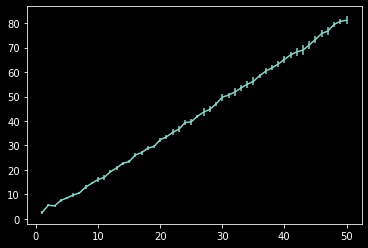

In [19]:
plt.errorbar(np.arange(1, 101), M_mean_perceptron, M_std_perceptron)

In [20]:
M_mean_winnow, M_std_winnow = complexity(50, 500, "winnow")

=>Start of method: WINNOW 
Process:100.00%, Epoch = 10, N = 50, M_mean = 26.5. ♥
End of method: WINNOW 



<ErrorbarContainer object of 3 artists>

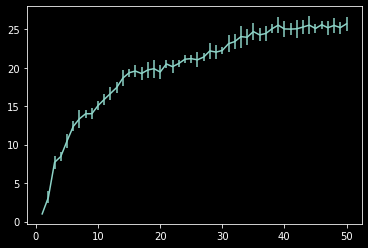

In [21]:
plt.errorbar(np.arange(1, 51), M_mean_winnow, M_std_winnow)

In [ ]:
M_mean_lsq, M_std_lsq = complexity(50, 500, "least_squares")

In [ ]:
plt.errorbar(np.arange(1, 51), M_mean_lsq, M_std_lsq)

In [ ]:
# %%time
# M_mean_list, M_std_list = long_long_long_computation(100, 500)